**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [9]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v - a) - np.log(b - v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return log_likelihood

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return (dloglik_dv.flatten() * dv_du.flatten())

GPU: []


## Forward modeling

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 27


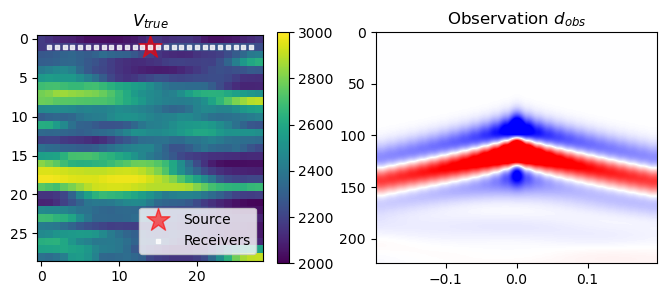

In [46]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = zxrec1
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [47]:
# # Model size (nz,nx) = (200,200)

# import pickle
# # load data
# filename = './data/u_200'
# infile = open(filename, 'rb')
# u_ref = pickle.load(infile)
# infile.close()

# filename = './data/Q_200'
# infile = open(filename, 'rb')
# Q = pickle.load(infile)
# infile.close()

# # Initialize the model axis az, ax, at
# nz,nx,nt = 200,200,800
# vmin,vmax = 2000,3000
# izsrc, ixsrc = [nz//100], [nx//2]
# next = 100

# # u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
# v_ref = f(u_ref)
# print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# az, ax, at, next, wsrc, zxsrc = defmodel(
#                       vmin=vmin, vmax=vmax, fmax=25, # key parameters
#                       nz=nz, nx=nx, nt=nt, # number of indices
#                       izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
#                       ext=next)  
# dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# # check_model(v=v_ref, vmin=vmin, vmax=vmax)
# # Set receiver z and x coordinates
# interv = 5 # interval between receivers
# receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
# 							np.arange(zxsrc[1][0],nx,interv)) #right
# nrec = len(receivers_width)
# # zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
# zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
# zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
# zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
# zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
# zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
# zxrec = np.unique(zxrec,axis=1)
# print("Number of receivers:", len(zxrec.flatten())//2)
# # # Propagajtion
# p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
# print("shape of p(z,x,t) =", p.shape)
# d_obs = p[zxrec[0], zxrec[1], :]

# plt.figure(figsize=(10,4),dpi=300)
# plt.subplot(1,2,1) 
# plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
# plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.title("$V_{true}$",fontsize=labelsize+4)
# plt.subplot(1,2,2)
# maxd = np.abs(d_obs).max()
# plt.imshow(d_obs.T,cmap='bwr',vmin=-maxd,vmax=maxd,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
# cbar = plt.colorbar()
# cbar.set_label("Amplitude")
# # plt.title("$d_{obs}$ with noise $\sigma_{Noise}$=%.2f  " % std_noise, fontsize=labelsize)
# plt.title("$d_{obs}$", fontsize=labelsize)
# plt.xlabel('Receiver distance (m)', fontsize=labelsize)
# plt.ylabel('Time (s)', fontsize=labelsize)
# plt.tight_layout()
# plt.show()

## Inversion with prior regularization term

In [48]:
# # load FWI result
# filename = './data/u_200_fwi'
# infile = open(filename, 'rb')
# u_fwi = pickle.load(infile)
# infile.close()

# u_fwi = u_fwi.flatten()
# u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
# v_init = f(u_init)   # Initial v
# std_noise = 0.1

In [49]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 1995.3508 Penalty term = 0.0000 Total loss = 1995.3508 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          841     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99535D+03    |proj g|=  4.05019D+01
Loss (J) = 1595.5870 Penalty term = 0.0027 Total loss = 1595.5897 
Loss (J) = 521.4757 Penalty term = 0.0675 Total loss = 521.5432 


 This problem is unconstrained.



At iterate    1    f=  5.21543D+02    |proj g|=  1.80821D+01
Loss (J) = 179.6060 Penalty term = 0.1407 Total loss = 179.7467 

At iterate    2    f=  1.79747D+02    |proj g|=  3.93216D+00
Loss (J) = 114.9499 Penalty term = 0.1246 Total loss = 115.0745 

At iterate    3    f=  1.15074D+02    |proj g|=  2.87468D+00
Loss (J) = 40.7204 Penalty term = 0.0971 Total loss = 40.8175 

At iterate    4    f=  4.08175D+01    |proj g|=  1.62762D+00
Loss (J) = 23.8466 Penalty term = 0.0886 Total loss = 23.9352 

At iterate    5    f=  2.39352D+01    |proj g|=  1.33058D+00
Loss (J) = 17.2643 Penalty term = 0.1015 Total loss = 17.3658 

At iterate    6    f=  1.73658D+01    |proj g|=  9.92310D-01
Loss (J) = 13.8370 Penalty term = 0.1098 Total loss = 13.9468 

At iterate    7    f=  1.39468D+01    |proj g|=  1.04061D+00
Loss (J) = 9.8036 Penalty term = 0.1241 Total loss = 9.9276 

At iterate    8    f=  9.92764D+00    |proj g|=  8.88086D-01
Loss (J) = 7.5850 Penalty term = 0.1282 Total loss = 7.7132 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 3.1837 Penalty term = 0.1145 Total loss = 3.2981 

At iterate   32    f=  3.29813D+00    |proj g|=  1.32915D-01
Loss (J) = 3.1099 Penalty term = 0.1131 Total loss = 3.2230 

At iterate   33    f=  3.22303D+00    |proj g|=  1.49863D-01
Loss (J) = 2.9487 Penalty term = 0.1095 Total loss = 3.0582 

At iterate   34    f=  3.05816D+00    |proj g|=  1.35468D-01
Loss (J) = 2.8196 Penalty term = 0.1058 Total loss = 2.9254 

At iterate   35    f=  2.92536D+00    |proj g|=  1.51591D-01
Loss (J) = 2.7500 Penalty term = 0.1046 Total loss = 2.8547 

At iterate   36    f=  2.85467D+00    |proj g|=  7.95819D-02
Loss (J) = 2.7093 Penalty term = 0.1032 Total loss = 2.8125 

At iterate   37    f=  2.81254D+00    |proj g|=  1.13829D-01
Loss (J) = 2.6449 Penalty term = 0.1015 Total loss = 2.7463 

At iterate   38    f=  2.74633D+00    |proj g|=  1.58505D-01
Loss (J) = 2.5423 Penalty term = 0.1020 Total loss = 2.6443 

At iterate   39    f=  2.64428D+00    |proj g|=  2.77143D-01
Loss (J) = 2.372


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 37.6983 Penalty term = 0.1832 Total loss = 37.8815 
Loss (J) = 0.5007 Penalty term = 0.1856 Total loss = 0.6863 

At iterate   81    f=  6.86335D-01    |proj g|=  1.65231D-01
Loss (J) = 0.4626 Penalty term = 0.1844 Total loss = 0.6470 

At iterate   82    f=  6.46988D-01    |proj g|=  9.48561D-02
Loss (J) = 0.4520 Penalty term = 0.1834 Total loss = 0.6354 

At iterate   83    f=  6.35381D-01    |proj g|=  7.72258D-02
Loss (J) = 0.4292 Penalty term = 0.1793 Total loss = 0.6085 

At iterate   84    f=  6.08526D-01    |proj g|=  8.48240D-02
Loss (J) = 0.4012 Penalty term = 0.1755 Total loss = 0.5767 

At iterate   85    f=  5.76727D-01    |proj g|=  6.80971D-02
Loss (J) = 0.3818 Penalty term = 0.1705 Total loss = 0.5524 

At iterate   86    f=  5.52353D-01    |proj g|=  6.05725D-02
Loss (J) = 0.3662 Penalty term = 0.1701 Total loss = 0.5363 

At iterate   87    f=  5.36315D-01    |proj g|=  4.58019D-02
Loss (J) = 0.3609 Penalty term = 0.1699 Total loss = 0.5308 

At iterate   8


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 1.4927 Penalty term = 0.1138 Total loss = 1.6065 
Loss (J) = 0.2047 Penalty term = 0.1154 Total loss = 0.3201 

At iterate  123    f=  3.20113D-01    |proj g|=  3.03175D-02
Loss (J) = 0.2026 Penalty term = 0.1152 Total loss = 0.3179 

At iterate  124    f=  3.17856D-01    |proj g|=  2.33733D-02
Loss (J) = 0.2016 Penalty term = 0.1152 Total loss = 0.3167 

At iterate  125    f=  3.16718D-01    |proj g|=  1.64279D-02
Loss (J) = 0.2012 Penalty term = 0.1150 Total loss = 0.3161 

At iterate  126    f=  3.16147D-01    |proj g|=  1.75944D-02
Loss (J) = 0.2015 Penalty term = 0.1146 Total loss = 0.3161 

At iterate  127    f=  3.16140D-01    |proj g|=  1.69986D-02
Loss (J) = 0.2029 Penalty term = 0.1140 Total loss = 0.3169 
Loss (J) = 0.2016 Penalty term = 0.1145 Total loss = 0.3161 

At iterate  128    f=  3.16089D-01    |proj g|=  1.63655D-02
Loss (J) = 0.2044 Penalty term = 0.1130 Total loss = 0.3174 
Loss (J) = 0.2017 Penalty term = 0.1142 Total loss = 0.3159 

At iterate  129  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 0.3369 Penalty term = 0.1000 Total loss = 0.4368 
Loss (J) = 0.2043 Penalty term = 0.1002 Total loss = 0.3046 

At iterate  137    f=  3.04560D-01    |proj g|=  1.44951D-02
Loss (J) = 0.2031 Penalty term = 0.1001 Total loss = 0.3033 

At iterate  138    f=  3.03274D-01    |proj g|=  1.99073D-02
Loss (J) = 0.2012 Penalty term = 0.1000 Total loss = 0.3012 

At iterate  139    f=  3.01199D-01    |proj g|=  1.52953D-02
Loss (J) = 0.1956 Penalty term = 0.0994 Total loss = 0.2950 

At iterate  140    f=  2.94963D-01    |proj g|=  3.14117D-02
Loss (J) = 0.1899 Penalty term = 0.0990 Total loss = 0.2890 

At iterate  141    f=  2.88971D-01    |proj g|=  4.12934D-02
Loss (J) = 0.1883 Penalty term = 0.0989 Total loss = 0.2872 

At iterate  142    f=  2.87202D-01    |proj g|=  1.07101D-01
Loss (J) = 0.1857 Penalty term = 0.0987 Total loss = 0.2844 

At iterate  143    f=  2.84387D-01    |proj g|=  4.18287D-02
Loss (J) = 0.1840 Penalty term = 0.0982 Total loss = 0.2822 

At iterate  144 

## FWI result

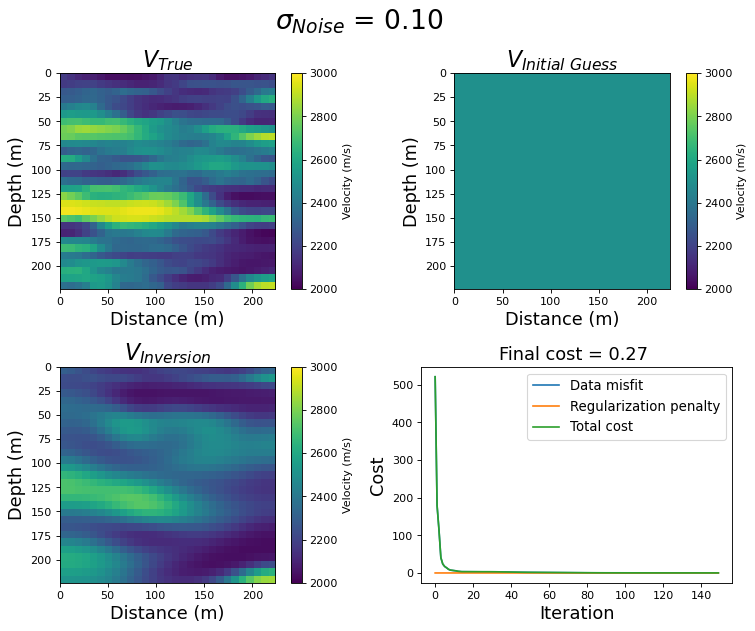

In [50]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# Variational Inference

**Set up the optimization and defines the prior and variational posterior distributions**

In [172]:
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = std_noise
# prior_cov = np.linalg.inv(Q)
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = 1/Q.diagonal()
prior_scale = tf.cast(tf.sqrt(prior_cov), dtype=tf.float32)
p_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)

# Define the TensorFlow variables for the variational posterior mean and scale
# Initial q_mean
q_mean = tf.Variable(prior_mean) # Set prior mean as the Variational initial mean 
# q_mean = tf.Variable(u_fwi, dtype=tf.float32)    # Set deterministic FWI result as the Variational initial mean

# Use Transformed Variable to ensure that the variable remains positive during optimization.
# q_scale_init = prior_scale
q_scale_init = 0.1 * tf.ones(nz*nx, dtype=tf.float32)
# q_scale = tfp.util.TransformedVariable(q_scale_init, tfp.bijectors.Exp(), trainable=True)

q_cov_init = 0.1 * tf.eye(nz*nx, dtype=np.float32)
# q_cov = tfp.util.TransformedVariable(q_cov_init, tfp.bijectors.Exp(), trainable=True)
# q_cov_chol = tfp.util.TransformedVariable(tf.linalg.cholesky(q_cov_init), tfp.bijectors.FillTriangular(), trainable=True)
q_cov = tfp.util.TransformedVariable(q_cov_init, tfp.bijectors.FillTriangular(), trainable=True)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

**Train the Variational Posterior with Neg-ELBO Objective**

In [ ]:
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 100
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    # annealing_factor = tf.minimum(0.01 * tf.cast(optimizer.iterations+1, tf.float32), 1.0)
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_scale.trainable_variables[0]])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_scale
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_scale.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_scale.trainable_variables[0]])
        
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)
        
        # # Compute log(q) entropy terms and gradient of entropy
        # log_q = q_dist.log_prob(u_samples)
        # E_log_q= tf.reduce_mean(log_q)
        # grads_E_entropy = tape.gradient(E_log_q, [q_mean, q_scale.trainable_variables[0]])

        # Compute the KL(q||p) term 
        kl_divergence_q_p = annealing_factor * tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p
        
        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    # and apply them to the optimizer
    # grads = [-g for g in grads_E_log_likelihoods] + \
    #         [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grad1 = [-g for g in grads_E_log_likelihoods]
    grad2 = [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grads = [g1 + g2 for g1, g2 in zip(grad1, grad2)]
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))

### Full Covariance

In [177]:
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 100
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    # annealing_factor = tf.minimum(0.01 * tf.cast(optimizer.iterations+1, tf.float32), 1.0)
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_cov.trainable_variables[0]])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalFullCovariance(loc=q_mean, covariance_matrix=q_cov)
        # q_dist = tfp.distributions.MultivariateNormalTriL(loc=q_mean, scale_tril=tf.linalg.cholesky(q_cov))

        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_cov
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_cov.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_cov.trainable_variables[0]])

        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))

        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)

        # Compute the KL(q||p) term 
        kl_divergence_q_p = annealing_factor * tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, q_cov.trainable_variables[0]])



Learning Rate: 0.10000000149011612
Iteration 1/100


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [178]:
du_dq

[None, None]

**Visualization of Prior and Posterior Distributions and Training History**

4.308438973037951


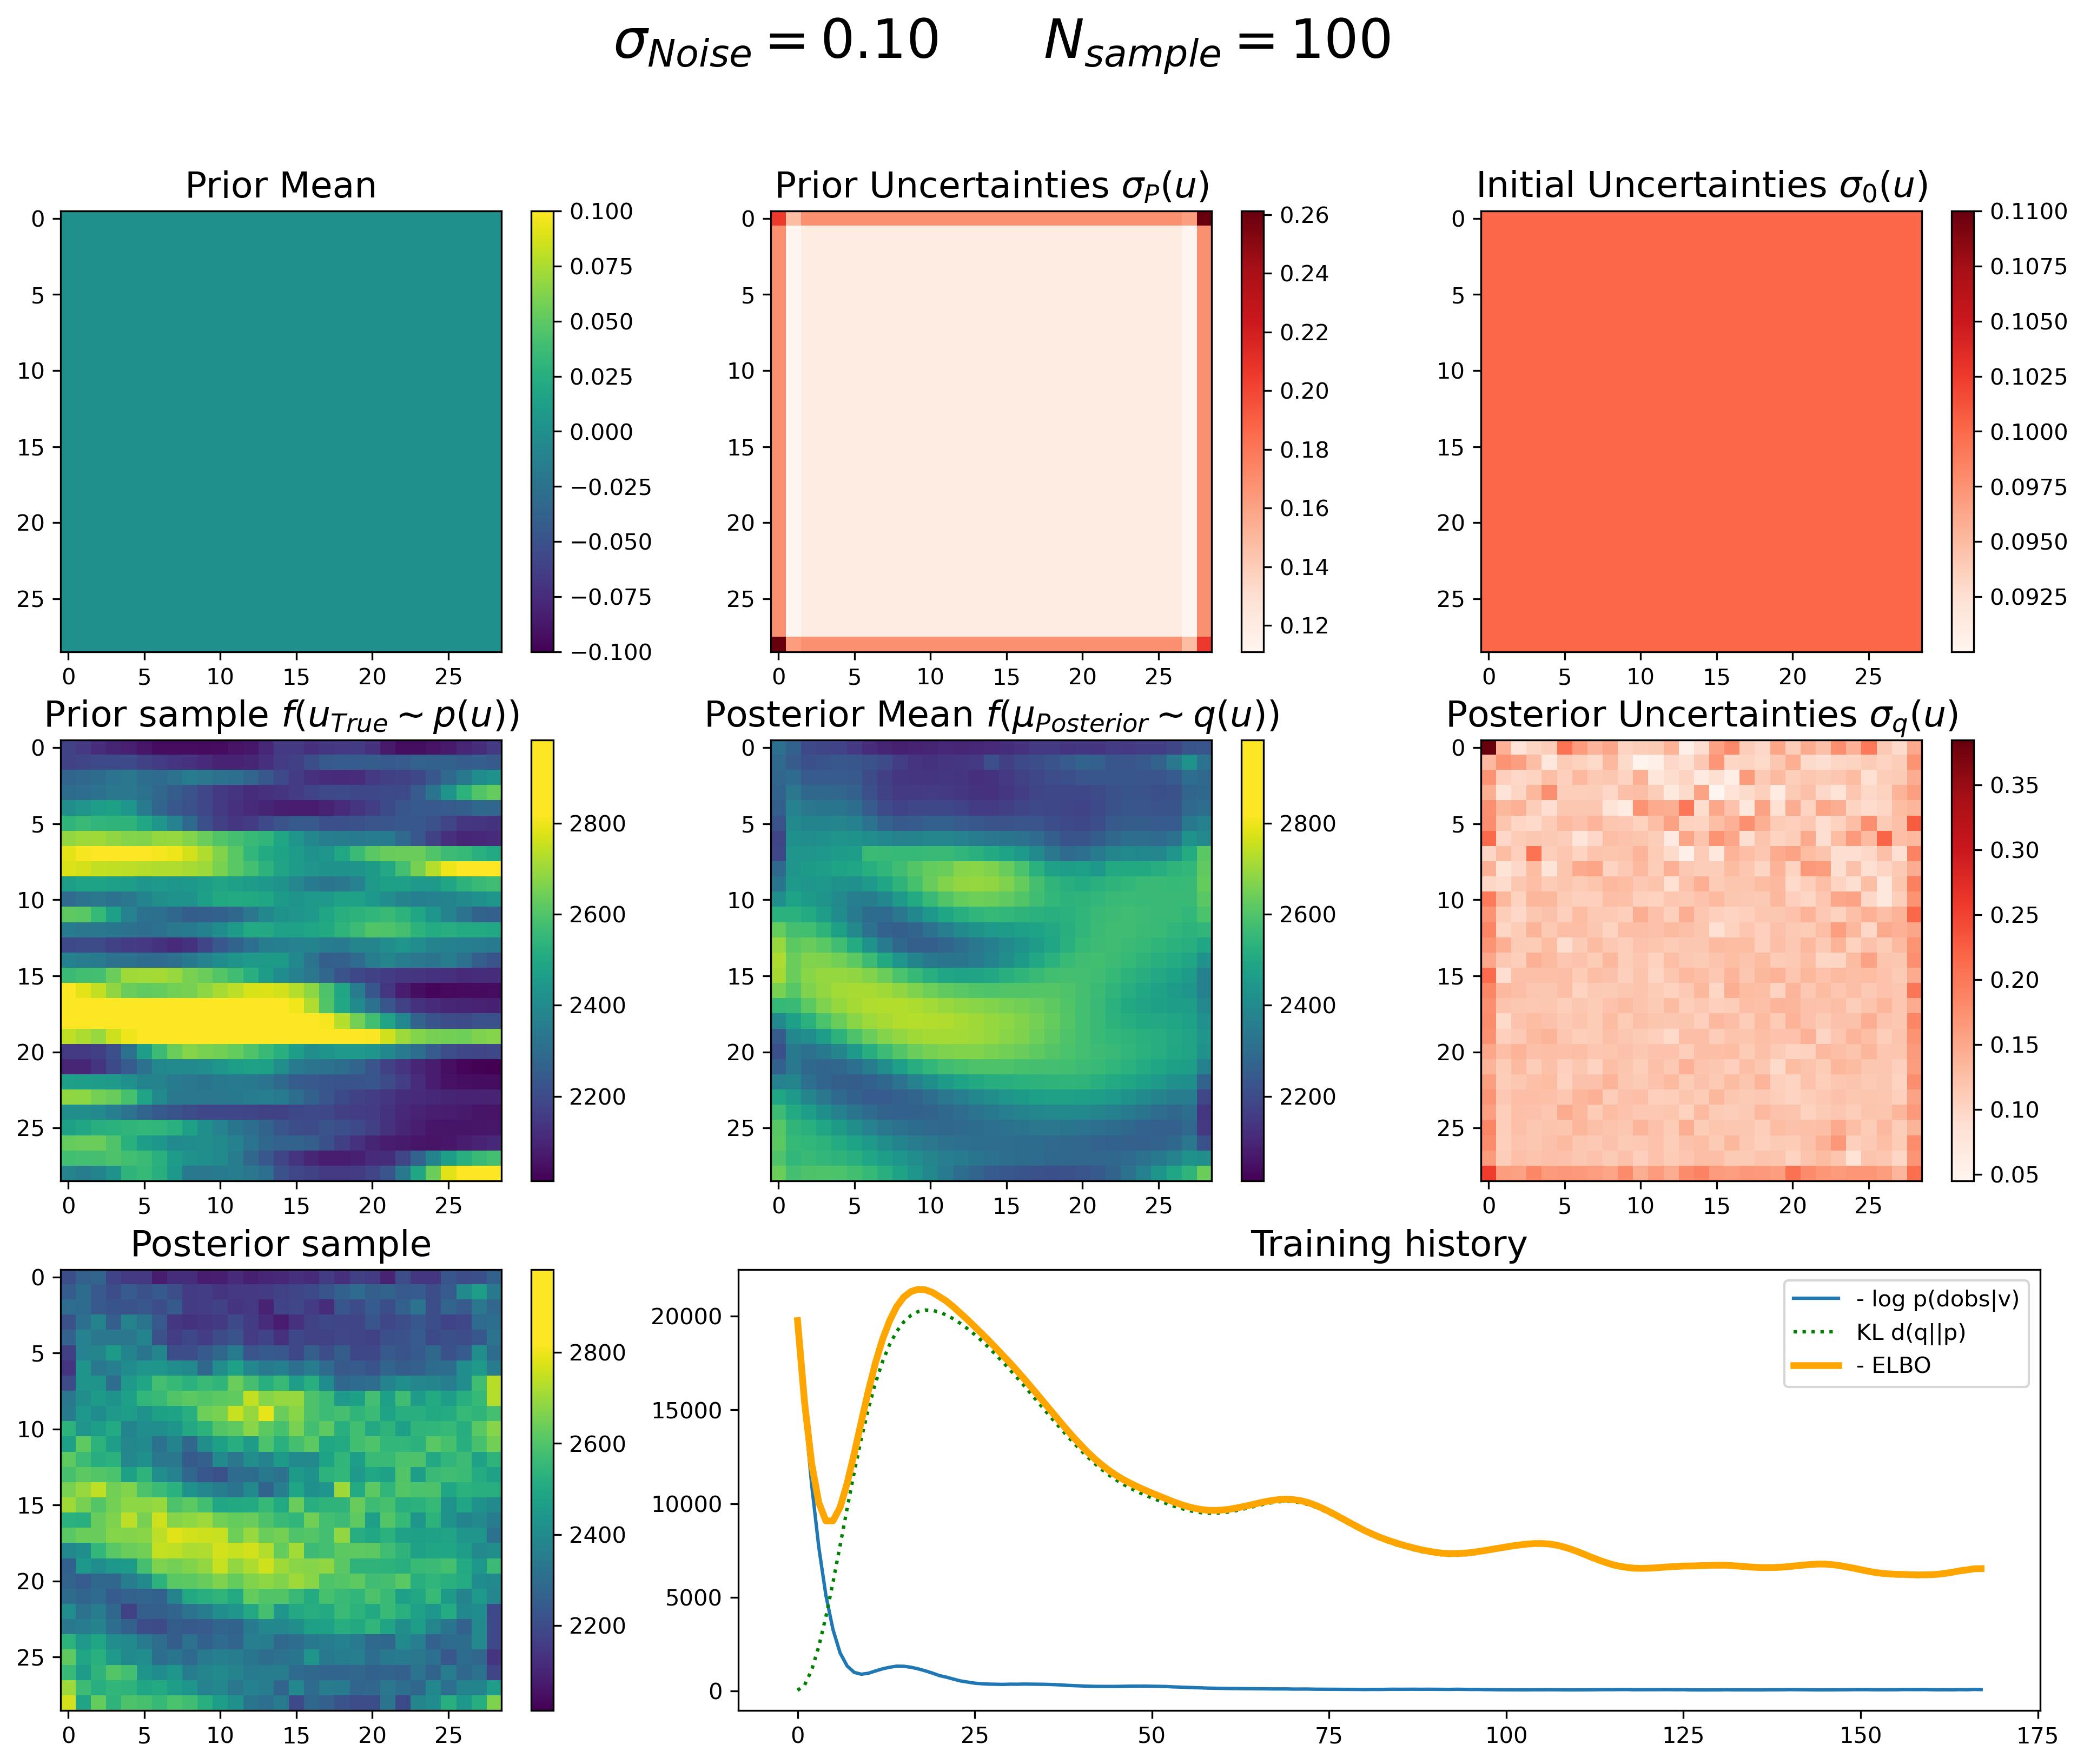

In [117]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
vmin, vmax = f(u_ref).min(), f(u_ref).max()

print(J(f(q_posterior.mean().numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device))

from matplotlib import cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('viridis', 512)
cmp = ListedColormap(viridisBig(np.linspace(0, 1.2, 256)))
Reds = cm.get_cmap('Reds', 512)
cmp_red = ListedColormap(Reds(np.linspace(0, 1, 256)))

plt.figure(figsize=(16,12),dpi=300)
plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + "    $N_{sample}=$"+str(num_samples),fontsize=labelsize+8)
plt.subplot(3,3,1)
plt.imshow(tf.reshape(p_dist.mean(),[nz,nx]))
plt.colorbar()
plt.title("Prior Mean", fontsize=16)

plt.subplot(3,3,2)
plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Prior Uncertainties $\sigma_{P}(u)$", fontsize=16)

plt.subplot(3,3,3)
plt.imshow(tf.reshape(q_scale_init,[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Initial Uncertainties $\sigma_{0}(u)$", fontsize=16)

plt.subplot(3,3,4)
plt.imshow(f(u_ref).reshape((nz,nx)),vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

plt.subplot(3,3,5)
plt.imshow(f(q_posterior.mean().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Posterior Mean $f(\mu_{Posterior} \sim q(u))$", fontsize=16)

plt.subplot(3,3,6)
plt.imshow(tf.reshape(q_posterior.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

plt.subplot(3,3,7)
plt.imshow(f(q_posterior.sample().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Posterior sample", fontsize=16)

plt.subplot(3,3,(8,9))
plt.plot(neg_loglik_history, label='- log p(dobs|v)')
plt.plot(kl_history, ls=":", label='KL d(q||p)', color='green')
plt.plot(neg_elbo_history, lw=3, label='- ELBO', color='orange')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()

Text(0.5, 1.0, '$v_{fwi}$')

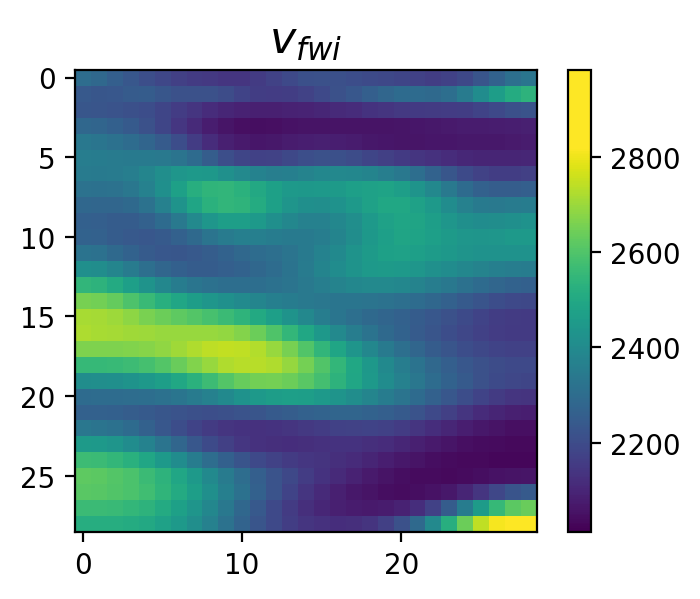

In [127]:
plt.figure(figsize=(4,3),dpi=200)
plt.imshow(v_fwi.reshape(nz,nx).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("$v_{fwi}$", fontsize=16)